# Skeleton Code

<hr>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV


### 1. 전처리

#### 1-0. 예측 레이블 정의

In [3]:
# path = './seoul_semi.csv' # 위치에 맞게 수정하세유
# df = pd.read_csv(path)

# df['환산_보증금_월세'] = df.apply(lambda x: x['보증금(만원)'] + x['월세(만원)']*12*20, axis='columns')
# df = df.drop(['보증금(만원)', '월세(만원)'], axis=1)
# df = df.drop(['위도', '경도'], axis=1)
# # df = df.astype(int) # int로 바꾸면 안되는 정보가 존재.

# print(df.shape)
# df.head(5)

# df.to_csv("./seoul_data", index=False)

# df = pd.read_csv("./seoul_data")
# df.shape

# col_len = len(df.columns)
# X = df.iloc[:, :col_len - 1]
# Y = df.iloc[:, col_len - 1]

In [2]:
df = pd.read_csv("./seoul_data")
df.shape

col_len = len(df.columns)
X = df.iloc[:, :col_len - 1]
Y = df.iloc[:, col_len - 1]

# ----------------------------------------------------------------------------
train_ratio = 0.7  # train 데이터 비율
val_ratio = 0.2  # validation 데이터 비율
test_ratio = 0.1  # test 데이터 비율

# train, validation, test 데이터 분리
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_ratio, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=val_ratio/(train_ratio + val_ratio), shuffle=True)

# StandardScaler를 사용하여 데이터 정규화.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # train 기준으로 val, test를 정규화한다.
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# ----------------------------------------------------------------------------
# 사용 가능한 디바이스 목록 출력
print(device_lib.list_local_devices())

# 현재 사용 중인 디바이스 출력
print("현재 사용 중인 디바이스: ", tf.test.gpu_device_name())

# ----------------------------------------------------------------------------
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64]
class EpochEndCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(self.model.optimizer.lr)
        bs = self.model.optimizer.get_config()['batch_size']
        print(f"Epoch {epoch + 1} - lr={lr:.4f}, batch_size={bs}, val_mae={logs['val_mae']:.4f}, val_loss={logs['val_loss']:.4f}")
callbacks = [EpochEndCallback()]
dropout_rate = 0.2
# physical_devices = tf.config.list_physical_devices('GPU')
# print(physical_devices[0][0])
# tf.config.experimental.set_memory_growth(physical_devices[0], True)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 301062370606262631
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1404776859
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2753487946771681531
physical_device_desc: "device: 0, name: NVIDIA GeForce GT 1030, pci bus id: 0000:03:00.0, compute capability: 6.1"
xla_global_id: 416903419
]
현재 사용 중인 디바이스:  /device:GPU:0


In [20]:
batch_size = 64
dropout_rate = 0.2
learning_rate = 0.0004

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(len(Y_train)).batch(batch_size).prefetch(2)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='mse', metrics=['mae'])

In [4]:
history = model.fit(train_ds, epochs=15, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/15
37732/37732 [==============================] - 391s 10ms/step - loss: 150371232.0000 - mae: 7405.3979 - val_loss: 89297376.0000 - val_mae: 5476.3604
Epoch 2/15
37732/37732 [==============================] - 397s 10ms/step - loss: 102722768.0000 - mae: 6136.3940 - val_loss: 82930312.0000 - val_mae: 5162.0581
Epoch 3/15
37732/37732 [==============================] - 399s 11ms/step - loss: 94422480.0000 - mae: 5849.2319 - val_loss: 103822560.0000 - val_mae: 5040.0093
Epoch 4/15
37732/37732 [==============================] - 401s 11ms/step - loss: 89808520.0000 - mae: 5678.1470 - val_loss: 84263552.0000 - val_mae: 4815.0342
Epoch 5/15
37732/37732 [==============================] - 405s 11ms/step - loss: 86732120.0000 - mae: 5573.9316 - val_loss: 75869400.0000 - val_mae: 4767.4116
Epoch 6/15
37732/37732 [==============================] - 407s 11ms/step - loss: 84175232.0000 - mae: 5482.7749 - val_loss: 85307904.0000 - val_mae: 4767.0117
Epoch 7/15
37732/37732 [===================

#### 1-1. train, test, val Split

In [4]:
# train_ratio = 0.7  # train 데이터 비율
# val_ratio = 0.2  # validation 데이터 비율
# test_ratio = 0.1  # test 데이터 비율

# # train, validation, test 데이터 분리
# X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_ratio, shuffle=True)
# X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=val_ratio/(train_ratio + val_ratio), shuffle=True)


#### 1-2. Scaling

In [11]:
# # StandardScaler를 사용하여 데이터 정규화.
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train) # train 기준으로 val, test를 정규화한다.
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

#### 1-3. mini batch(+ shuffle), prefetch

In [10]:
# batch_size = 64
# train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(len(Y_train)).batch(batch_size).prefetch(2)

# batch_size = 64
# train_ds = tf.data.Dataset.from_tensor_slices((X, Y)).shuffle(len(Y)).take(1).batch(batch_size).prefetch(2)
# train_array = tf.data.experimental.get_single_element(train_ds)


### 2. Modeling

In [11]:
# from sklearn.preprocessing import StandardScaler

# X = StandardScaler().fit_transform(X)  # 데이터 스케일링
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)  # 데이터 분리

# batch_size = 32
# train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
# train_ds = train_ds.shuffle(buffer_size=X_train.shape[0])
# train_ds = train_ds.batch(batch_size)
# train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
# test_ds = test_ds.batch(batch_size)
# test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


#### 모델링, 컴파일

In [12]:
# batch_size = 64
# dropout_rate = 0.2
# learning_rate = 0.001

# train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(len(Y_train)).batch(batch_size).prefetch(2)

# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(dropout_rate),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(dropout_rate),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(dropout_rate),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(dropout_rate),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(dropout_rate),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(dropout_rate),
#     tf.keras.layers.Dense(1)
# ])


# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# model.compile(optimizer=opt, loss='mse', metrics=['mae'])

In [13]:
# with tf.device("/device:GPU:0"):
#     history = model.fit(train_ds, epochs=10, validation_data=(X_val, Y_val), verbose=1)


#### 그리드 서치 산출물

In [12]:
# from tensorflow.python.client import device_lib

# # 사용 가능한 디바이스 목록 출력
# print(device_lib.list_local_devices())

# # 현재 사용 중인 디바이스 출력
# import tensorflow as tf
# print("현재 사용 중인 디바이스: ", tf.test.gpu_device_name())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14090869675151127166
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1404776859
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15720717129492621524
physical_device_desc: "device: 0, name: NVIDIA GeForce GT 1030, pci bus id: 0000:03:00.0, compute capability: 6.1"
xla_global_id: 416903419
]
현재 사용 중인 디바이스:  /device:GPU:0


In [14]:
# learning_rates = [0.01, 0.001, 0.0001]
# batch_sizes = [32, 64]

# class EpochEndCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         lr = float(self.model.optimizer.lr)
#         bs = self.model.optimizer.get_config()['batch_size']
#         print(f"Epoch {epoch + 1} - lr={lr:.4f}, batch_size={bs}, val_mae={logs['val_mae']:.4f}, val_loss={logs['val_loss']:.4f}")

# callbacks = [EpochEndCallback()]


In [18]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# # if gpus:
# #     try:
# #         tf.config.experimental.set_virtual_device_configuration(
# #             gpus[0],
# #             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])
# #     except RuntimeError as e:
# #         print(e)

# # GPU 메모리 사용량을 자동으로 늘려가게 설정
# if gpus:
#     for gpu in gpus:
#         try:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         except RuntimeError as e:
#             print(e)


In [19]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Restrict TensorFlow to only allocate memory when needed
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)


In [20]:
# # 특정 GPU 지정
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(physical_devices[0], 'GPU')

# 모든 GPU 사용
# tf.config.set_visible_devices(physical_devices, 'GPU')


In [21]:
# physical_devices = tf.config.list_physical_devices('GPU')
# print(physical_devices[0][0])
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

/physical_device:GPU:0


In [15]:
# from sklearn.model_selection import GridSearchCV
# dropout_rate = 0.2

# def create_model(learning_rate=0.001):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(16, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate),
#         tf.keras.layers.Dense(1)
#     ])
#     opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(optimizer=opt, loss='mse', metrics=['mae'])
#     return model

# model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, verbose=2)

# param_grid = {'batch_size': [16, 32], 'epochs': [10], 'learning_rate': [0.01, 0.001, 0.0001]}

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=3, verbose=2)
# grid_result = grid_search.fit(X_train, Y_train, callbacks=callbacks)

# # 최적의 결과 출력
# print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
# mean_scores = grid_result.cv_results_['mean_test_score']
# params = grid_result.cv_results_['params']
# for mean, param in zip(mean_scores, params):
#     print(f"Mean score: {mean:.4f} with: {param}")

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_25832\1617962113.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, verbose=2)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [ ]:
# from joblib import Parallel, delayed

# # 그래프를 그리기 위한 빈 리스트
# train_loss = []
# train_mae = []
# val_loss = []
# val_mae = []
# dropout_rate = 0.2
# def train_and_evaluate(lr, bs):
#     train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(len(Y_train)).batch(bs).prefetch(2)

#     model = tf.keras.Sequential([
#         # tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
#         # tf.keras.layers.BatchNormalization(),
#         # tf.keras.layers.Dropout(dropout_rate),
#         # tf.keras.layers.Dense(256, activation='relu'),
#         # tf.keras.layers.BatchNormalization(),
#         # tf.keras.layers.Dropout(dropout_rate),
#         # tf.keras.layers.Dense(128, activation='relu'),
#         # tf.keras.layers.BatchNormalization(),
#         # tf.keras.layers.Dropout(dropout_rate),
#         # tf.keras.layers.Dense(64, activation='relu'),
#         # tf.keras.layers.BatchNormalization(),
#         # tf.keras.layers.Dropout(dropout_rate),
#         # tf.keras.layers.Dense(32, activation='relu'),
#         # tf.keras.layers.BatchNormalization(),
#         # tf.keras.layers.Dropout(dropout_rate),
#         tf.keras.layers.Dense(16, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate),
#         tf.keras.layers.Dense(1)
#     ])

#     opt = tf.keras.optimizers.Adam(learning_rate=lr)
#     model.compile(optimizer=opt, loss='mse', metrics=['mae'])
#     history = model.fit(train_ds, epochs=10, validation_data=(X_val, Y_val), verbose=2, callbacks=callbacks)

#     val_mae.append(history.history['val_mae'][-1])
#     train_mae.append(history.history['mae'][-1])
#     val_loss.append(history.history['val_loss'][-1])
#     train_loss.append(history.history['loss'][-1])

#     if val_mae[-1] == min(val_mae):
#         best_lr = lr
#         best_batch_size = bs

#     print(f"lr={lr:.4f}, batch_size={bs}, val_mae={val_mae[-1]:.4f}")

# Parallel(n_jobs=-1, require='sharedmem')(delayed(train_and_evaluate)(lr, bs) for lr in learning_rates for bs in batch_sizes)

# plt.plot(train_loss, label='train_loss')
# plt.plot(val_loss, label='val_loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.plot(train_mae, label='train_mae')
# plt.plot(val_mae, label='val_mae')
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.legend()
# plt.show()


In [ ]:
# import os
# os.environ['TF_DISABLE_MKL'] = '1'

In [ ]:
# # 모델 학습
# with tf.device("/device:GPU:0"):
#     grid_result = grid.fit(X_train, Y_train, validation_data=(X_test, Y_test), callbacks=[early_stop])

In [ ]:
#model.save('./')

In [ ]:
# model = tf.keras.models.load_model('./aa/')
# model.summary()

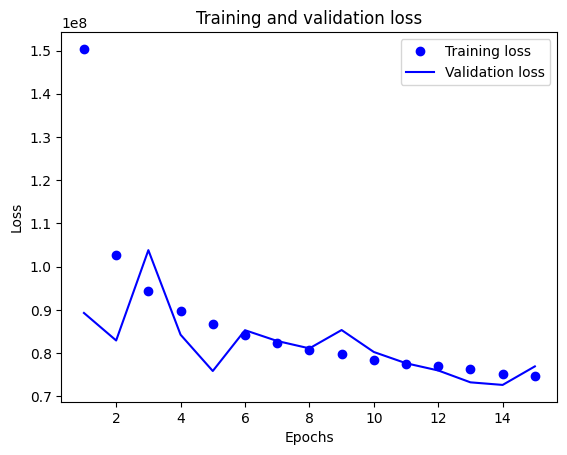

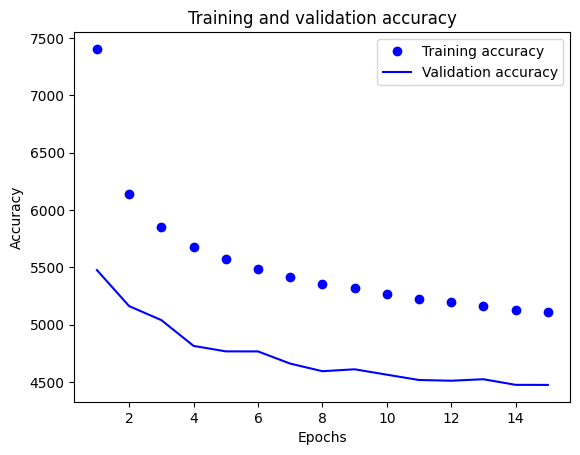

In [5]:
# training 과정에서의 loss 및 accuracy 시각화
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['mae']
val_acc = history.history['val_mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [6]:
Y_test_hat = model.predict(X_test).ravel().astype(int)

10781/10781 [==============================] - 20s 2ms/step


In [7]:
hat_s = Y_test_hat[1000:1020]
s = Y_test[1000:1020]

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_12532\3052720936.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  s = Y_test[1000:1020]


<Figure size 1000x600 with 0 Axes>

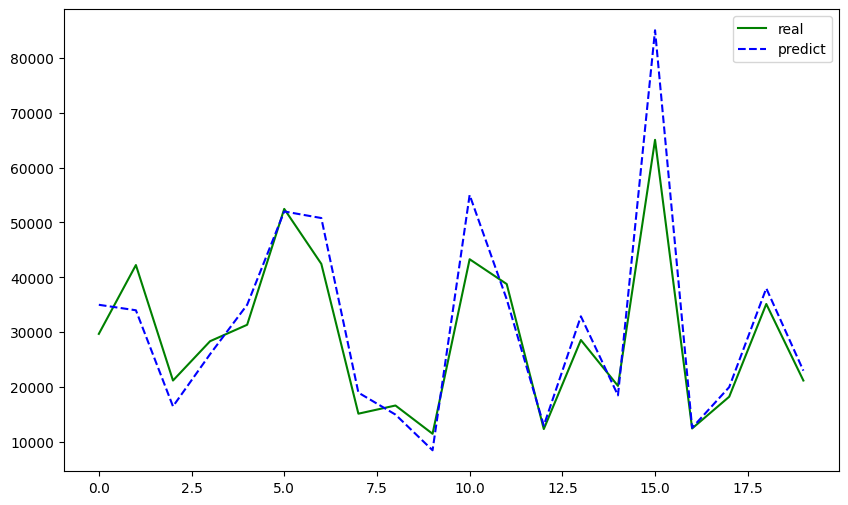

<Figure size 1000x600 with 0 Axes>

In [8]:
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(np.arange(20), hat_s, '-',color = 'green', label='real')
plt.plot(np.arange(20), s, '--', color = 'blue', label='predict')
plt.legend()
plt.figure()

In [9]:
hat_s = Y_test_hat[:100]
s = Y_test[:100]

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_12532\3046546549.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  s = Y_test[:100]


<Figure size 2000x1000 with 0 Axes>

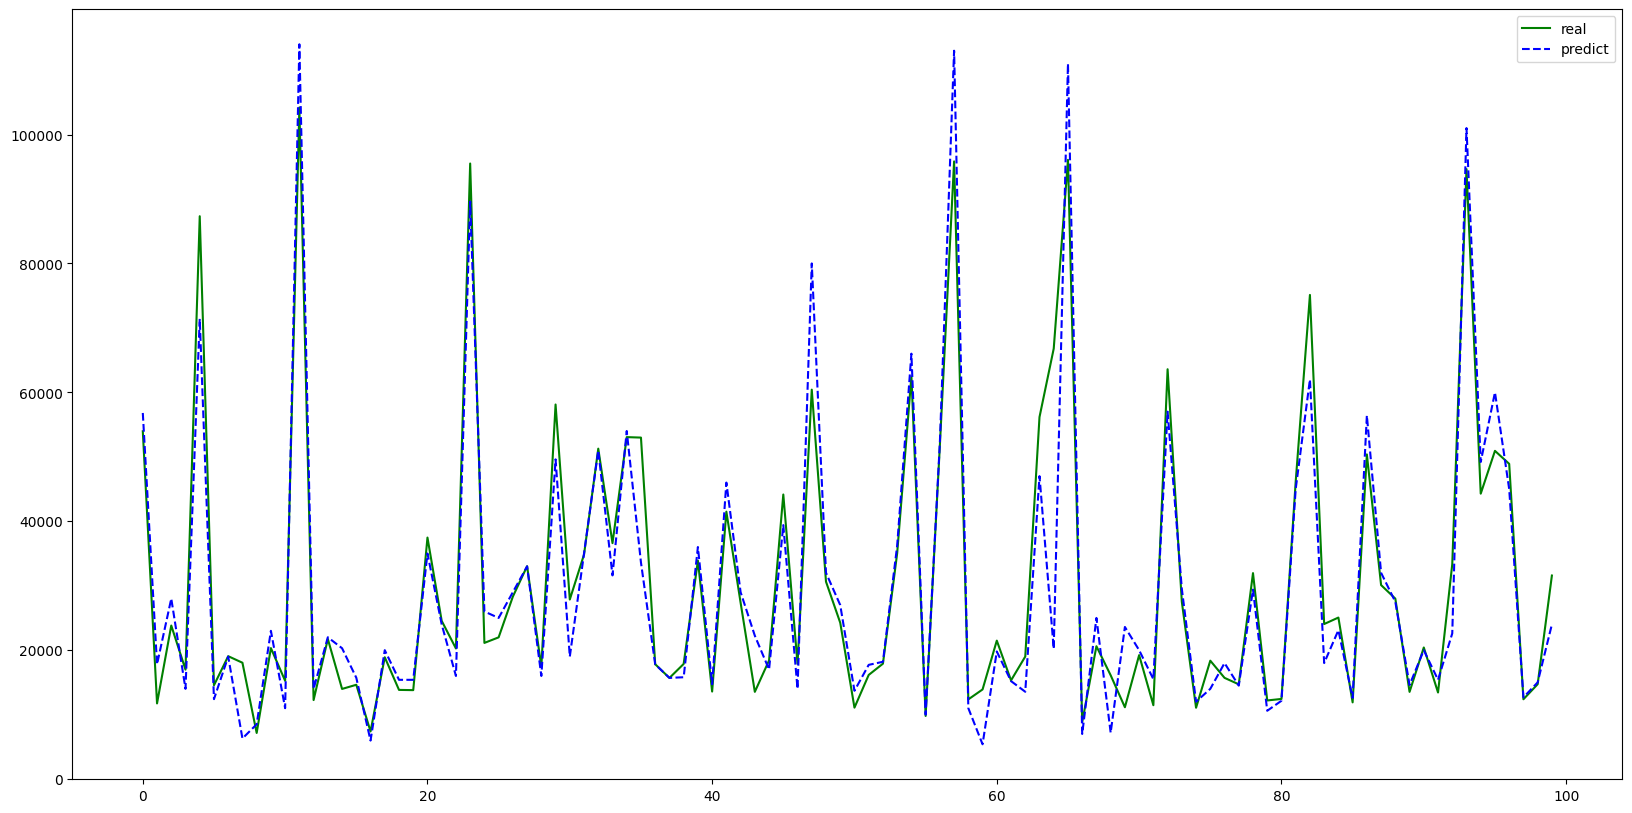

<Figure size 2000x1000 with 0 Axes>

In [10]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(100), hat_s, '-',color = 'green', label='real')
plt.plot(np.arange(100), s, '--', color = 'blue', label='predict')
plt.legend()
plt.figure()

<Figure size 2000x1000 with 0 Axes>

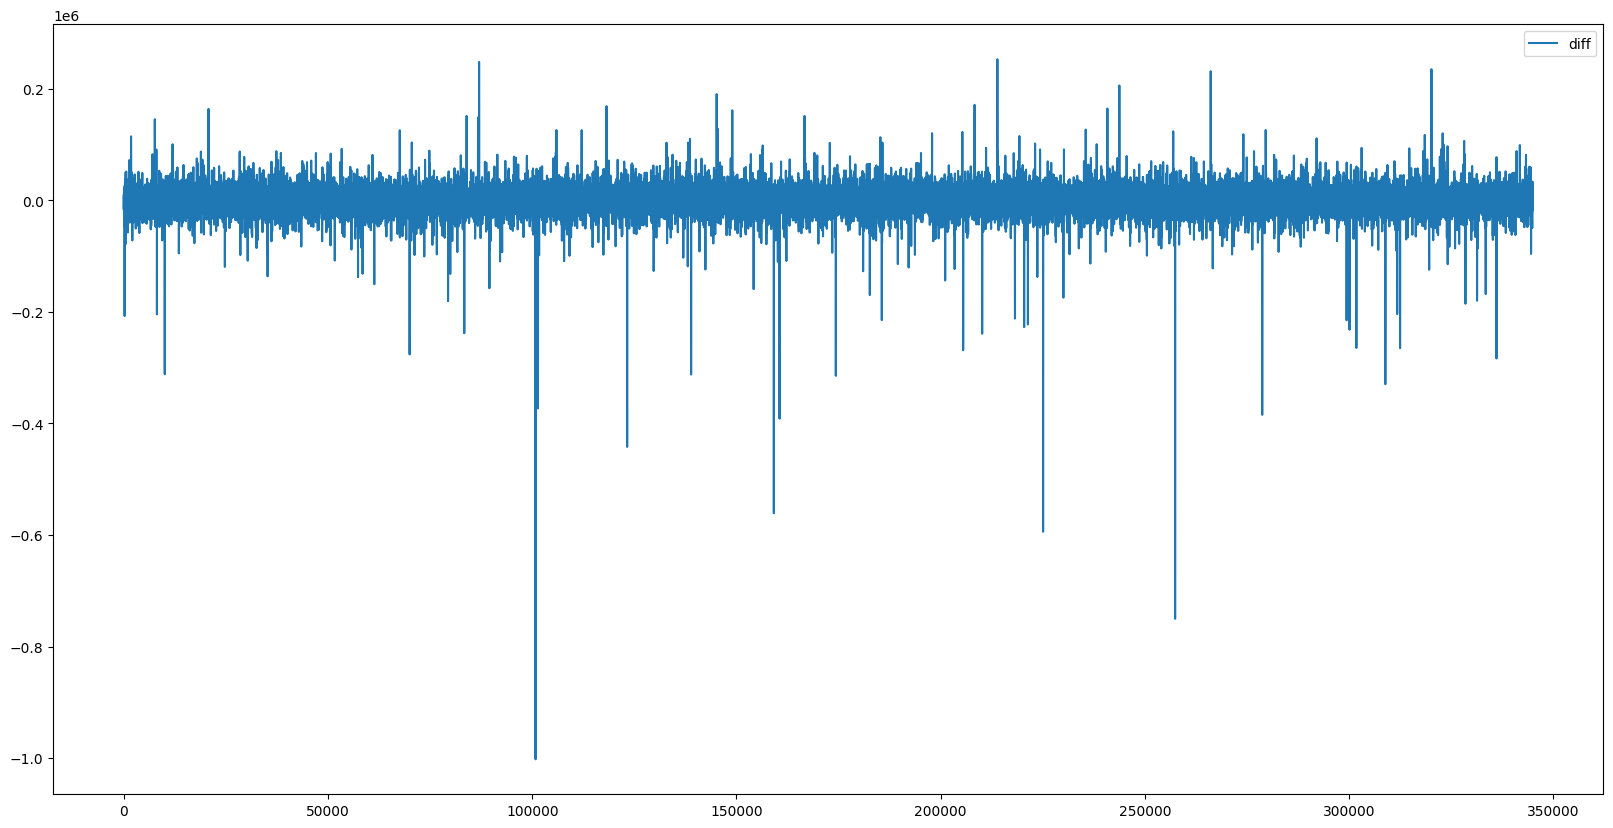

<Figure size 2000x1000 with 0 Axes>

In [11]:
diff = Y_test - Y_test_hat

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(344979), diff, '-', label='diff')
plt.legend()
plt.figure()

<Figure size 2000x1000 with 0 Axes>

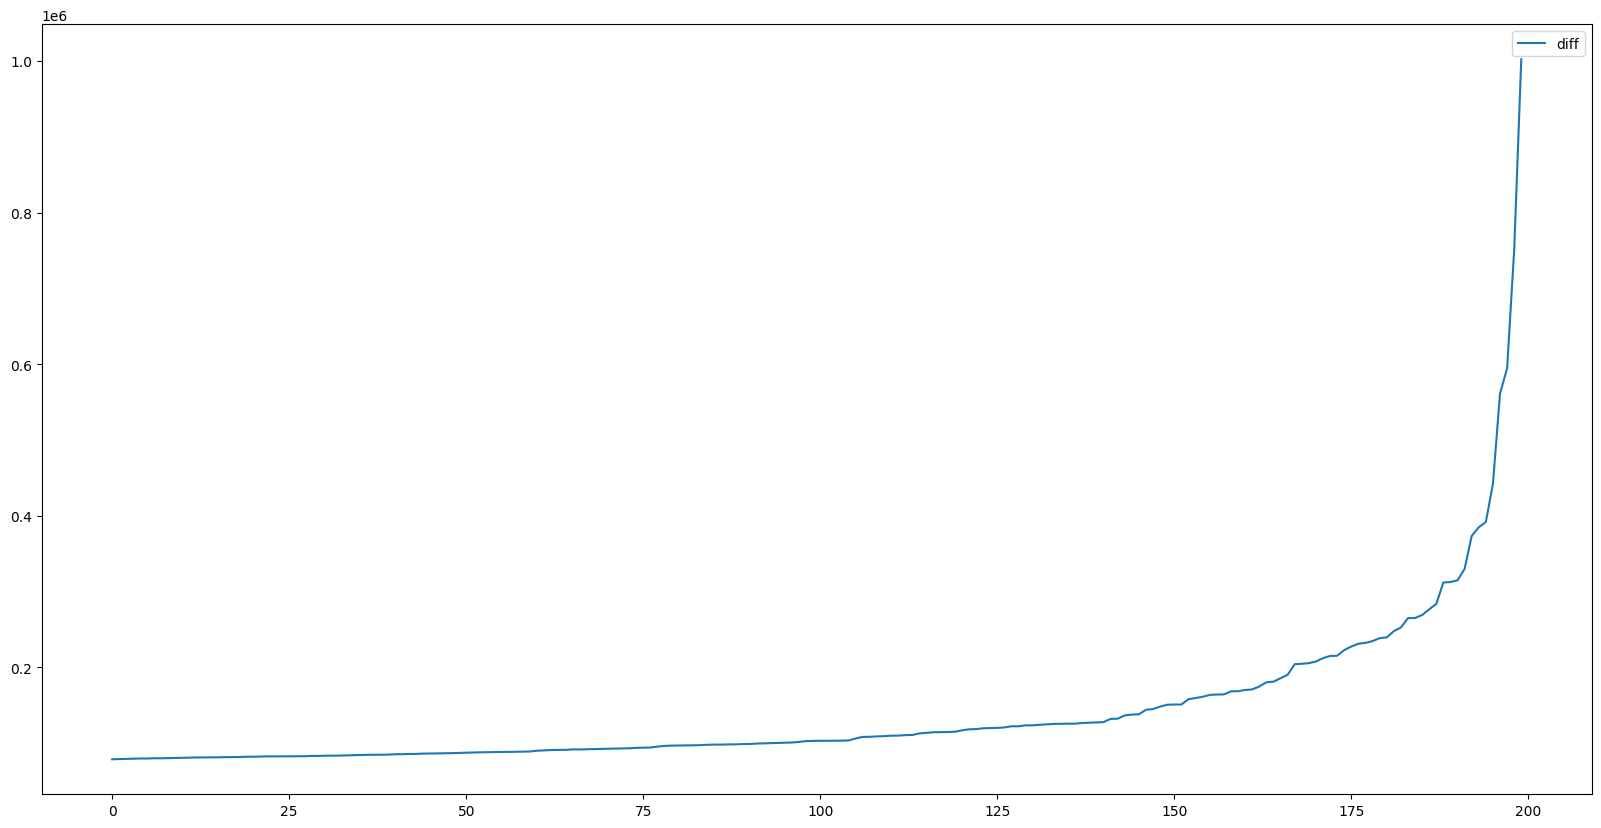

<Figure size 2000x1000 with 0 Axes>

In [12]:
sorted_diff = np.sort(np.abs(diff))[-200:]  # 오름차순으로 정렬
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(200), sorted_diff, '-', label='diff')
plt.legend()
plt.figure()

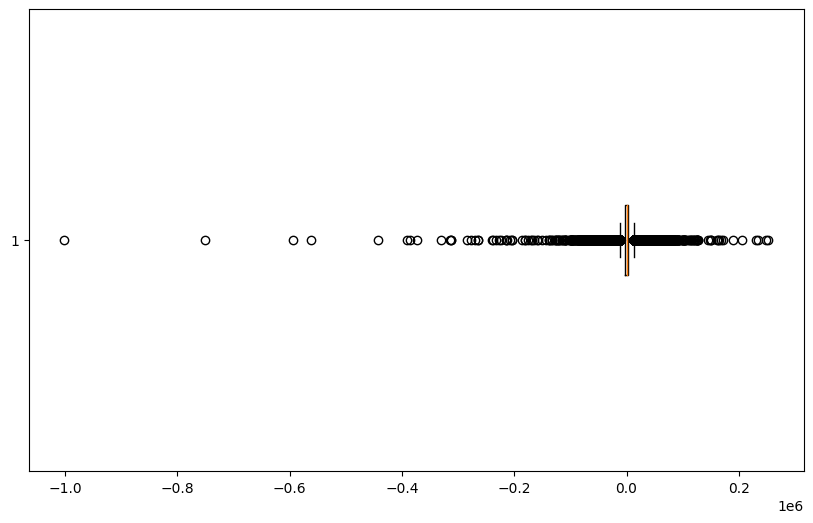

In [18]:
plt.rcParams["figure.figsize"] = (10,6)
plt.boxplot(diff, vert=False, whis=2)
plt.show()

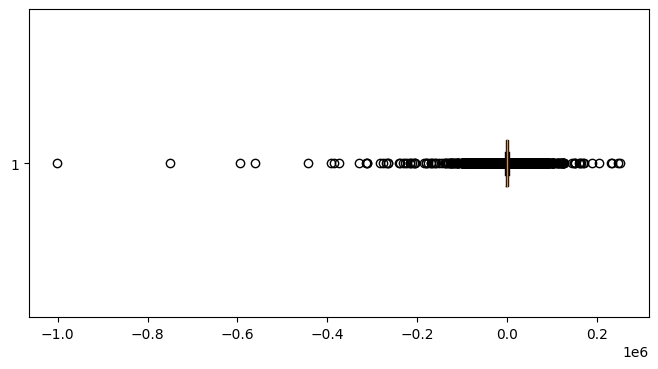

In [19]:
plt.rcParams["figure.figsize"] = (8,4)
plt.boxplot(diff, vert=False, whis=0.5)
plt.show()